In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41003,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34315,Total threads: 1
Dashboard: /proxy/35599/status,Memory: 0 B
Nanny: tcp://127.0.0.1:45681,


In [3]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

contour_depth = 1500.

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



CPU times: user 4.87 s, sys: 1.74 s, total: 6.61 s
Wall time: 6.83 s


# this match with the csv file, but when it loads for some reason it isn't right. Trying to debug this

In [ ]:
# fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'
# xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
# x_contour10 = xcon_np.tolist()
# ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
# y_contour10 = ycon_np.tolist()

In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_y_contour.csv")
y_contour = ycon_np.tolist()

In [ ]:
# plt.plot(x_contour10[0:-1],y_contour10[0:-1])
# # plt.xlim(100,350)
# # plt.ylim(0,300)

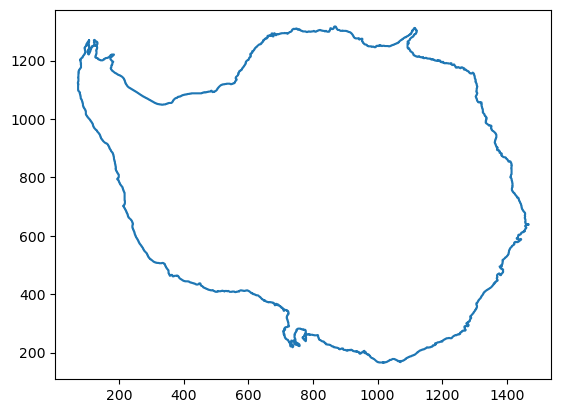

In [6]:
plt.plot(x_contour,y_contour)
# plt.xlim(1000,1100)
# plt.ylim(0,300)

In [ ]:
# print(len(x_contour10))

# # Difference between two neighbouring indices
# diff_x_contour10 = np.diff(x_contour10)
# diff_y_contour10 = np.diff(y_contour10)

# # Get a list with the indices of duplicates
# diff_ind10 = []
# for ii in range(len(diff_x_contour10)):
#     if (diff_x_contour10[ii]==0) and (diff_y_contour10[ii]==0):
#         diff_ind10.append(ii)

# # Now remove the indices (start from the end so the indices don't shift)
# for ii in range(len(diff_ind10)):
#     index = diff_ind10[::-1][ii]
#     del x_contour10[index]
#     del y_contour10[index]

# h_contour10 = np.zeros(len(x_contour10))
# print(len(h_contour10))

In [7]:
print(len(x_contour))

# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))
print(len(h_contour))

7149
5044


In [8]:
# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[int(y_contour[ii-1]),int(x_contour[ii-1])]
    lat_along_contour[ii] = y_var[int(y_contour[ii-1]),int(x_contour[ii-1])]

(5044,)

In [10]:
len(h_contour)

5044

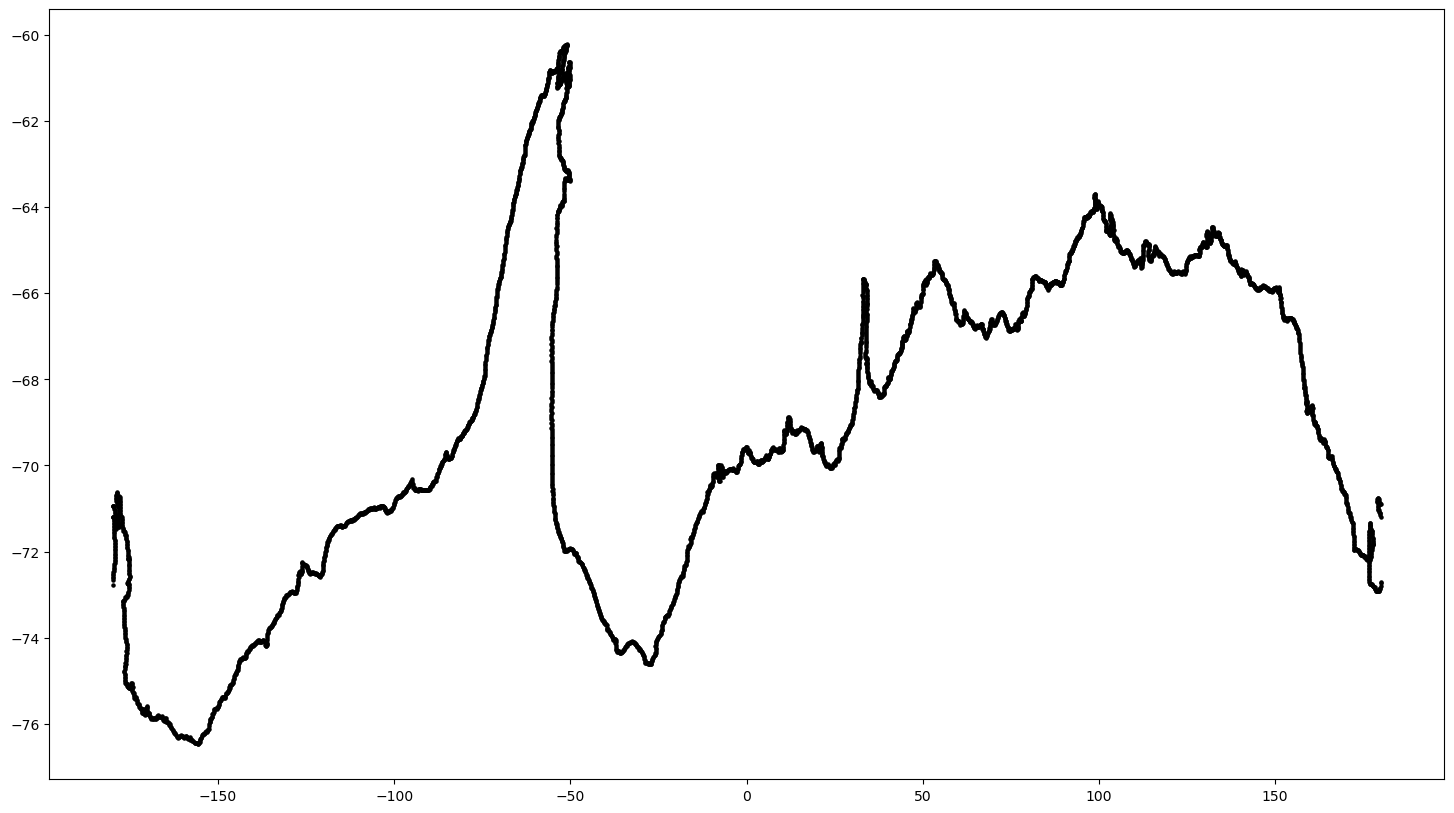

In [16]:
fig = plt.figure(figsize = (18, 10))

plt.scatter(lon_along_contour, lat_along_contour, s=5, alpha=1, color='k')

# plt.scatter(lon_along_contour[150:400], lat_along_contour[150:400], s=5, alpha=1, color='k');
# plt.scatter(lon_along_contour[400:450], lat_along_contour[400:450], s=5, alpha=1, color='r');
# plt.scatter(lon_along_contour[450:500], lat_along_contour[450:500], s=5, alpha=1, color='b');
# plt.xlim(-250,200)

# plot contours below

In [ ]:
fig = plt.figure(figsize = (18, 16))
count = 0
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=1470 #(494*2.5)
xf=8619 #(3279*2.5)
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');
plt.xlim(1000,1100)
plt.ylim(0,300)

In [ ]:
len(x_contour)

In [ ]:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]

fig = plt.figure(figsize = (18, 16))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');
plt.xlim(1000,1100)
plt.ylim(0,300)

In [ ]:
# save x_contour, y_contour

xcon_np = np.asarray(x_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_x_contour.csv", xcon_np, delimiter=",")

ycon_np = np.asarray(y_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_y_contour.csv", ycon_np, delimiter=",")

# xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_x_contour.csv")
# x_contour2 = xcon_np.tolist()
# ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_y_contour.csv")
# y_contour2 = ycon_np.tolist()


In [ ]:
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_x_contour.csv")
x_contour2 = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_1500m_y_contour.csv")
y_contour2 = ycon_np.tolist()

In [ ]:
len(x_contour2)